# Práctica 4: Eigen Faces and simple face detector with PCA

Integrantes de equipo:
1. Alfonso Murrieta Villegas 
2. C. Nathaniel Ceballos Equihua
3. Felipe de Jesús Solano González
4. Juan Muñoz Marbán


## 0. Bibliotecas y dataset


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from PIL import Image
import glob
import sys
import imageio
import os
import math
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [ ]:
!git clone https://github.com/aMurryFly/Pattern-Recognition.git

Cloning into 'Pattern-Recognition'...
remote: Enumerating objects: 4230, done.
remote: Counting objects: 100% (4230/4230), done.
remote: Compressing objects: 100% (969/969), done.
remote: Total 4230 (delta 3291), reused 4172 (delta 3252), pack-reused 0
Receiving objects: 100% (4230/4230), 147.41 MiB | 31.14 MiB/s, done.
Resolving deltas: 100% (3291/3291), done.
Checking out files: 100% (4095/4095), done.


In [ ]:
!ls
%cd Pattern-Recognition
!git pull
%cd ..

Pattern-Recognition  sample_data
/content/Pattern-Recognition
Already up to date.
/content


In [ ]:
all_images_dir = "/content/Pattern-Recognition/practices/practice_4/images"
all_images_list = glob.glob(all_images_dir + "/*")
all_images_list.sort()

De la descripción de los datos en https://courses.media.mit.edu/2004fall/mas622j/04.projects/faces/, se sabe que no existen las siguientes imágenes: 1228, 1232, 1808, 4056, 4135, 4136 y 5004.
Por otro lado, como se muestra, hay ciertas imágenes que no contienen información relevante (una cara), que son las que se muestran. Se obtienen al comprobar si la imagen tiene cierto porcentaje (en este caso, 11%) menor del total de píxeles que no son cero, o cierto porcentaje mayor al total (93%) de píxeles que no son cero. Como se observa, se obtienen dos excepciones (imágenes que sí son caras), por lo que se deben de tomar en cuenta.

In [ ]:
exception_list = ["/content/Pattern-Recognition/practices/practice_4/images/4289", "/content/Pattern-Recognition/practices/practice_4/images/4424"]

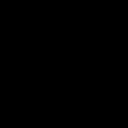

/content/Pattern-Recognition/practices/practice_4/images/2099



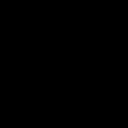

/content/Pattern-Recognition/practices/practice_4/images/2100



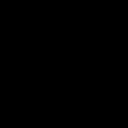

/content/Pattern-Recognition/practices/practice_4/images/2101



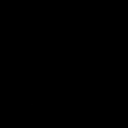

/content/Pattern-Recognition/practices/practice_4/images/2102



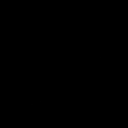

/content/Pattern-Recognition/practices/practice_4/images/2103



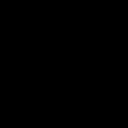

/content/Pattern-Recognition/practices/practice_4/images/2104



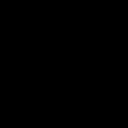

/content/Pattern-Recognition/practices/practice_4/images/2105



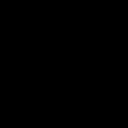

/content/Pattern-Recognition/practices/practice_4/images/2106



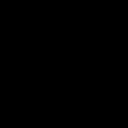

/content/Pattern-Recognition/practices/practice_4/images/3283



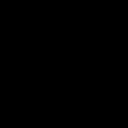

/content/Pattern-Recognition/practices/practice_4/images/3860



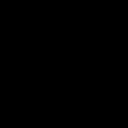

/content/Pattern-Recognition/practices/practice_4/images/3861



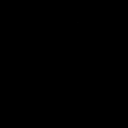

/content/Pattern-Recognition/practices/practice_4/images/3862



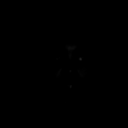

/content/Pattern-Recognition/practices/practice_4/images/3883



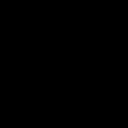

/content/Pattern-Recognition/practices/practice_4/images/4125



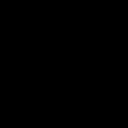

/content/Pattern-Recognition/practices/practice_4/images/4146



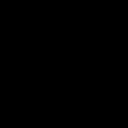

/content/Pattern-Recognition/practices/practice_4/images/4237



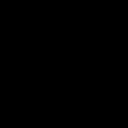

/content/Pattern-Recognition/practices/practice_4/images/4267



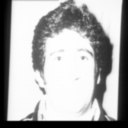

/content/Pattern-Recognition/practices/practice_4/images/4289



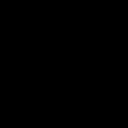

/content/Pattern-Recognition/practices/practice_4/images/4295



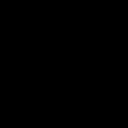

/content/Pattern-Recognition/practices/practice_4/images/4335



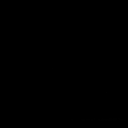

/content/Pattern-Recognition/practices/practice_4/images/4354



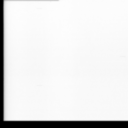

/content/Pattern-Recognition/practices/practice_4/images/4355



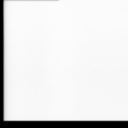

/content/Pattern-Recognition/practices/practice_4/images/4356



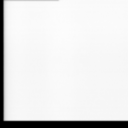

/content/Pattern-Recognition/practices/practice_4/images/4357



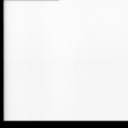

/content/Pattern-Recognition/practices/practice_4/images/4358



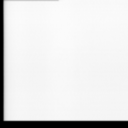

/content/Pattern-Recognition/practices/practice_4/images/4359



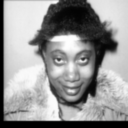

/content/Pattern-Recognition/practices/practice_4/images/4424



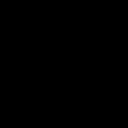

/content/Pattern-Recognition/practices/practice_4/images/4429



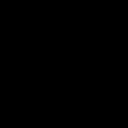

/content/Pattern-Recognition/practices/practice_4/images/4452



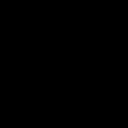

/content/Pattern-Recognition/practices/practice_4/images/4498



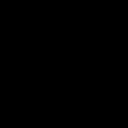

/content/Pattern-Recognition/practices/practice_4/images/4566



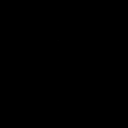

/content/Pattern-Recognition/practices/practice_4/images/4637



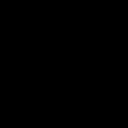

/content/Pattern-Recognition/practices/practice_4/images/4679



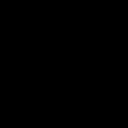

/content/Pattern-Recognition/practices/practice_4/images/4710



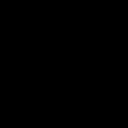

/content/Pattern-Recognition/practices/practice_4/images/4779



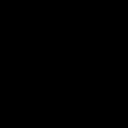

/content/Pattern-Recognition/practices/practice_4/images/4908



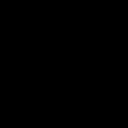

/content/Pattern-Recognition/practices/practice_4/images/4992



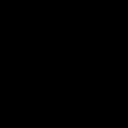

/content/Pattern-Recognition/practices/practice_4/images/5076



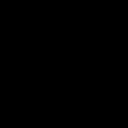

/content/Pattern-Recognition/practices/practice_4/images/5113



In [ ]:
all_images = []
for image in all_images_list:
  #print(image)
  img = np.fromfile(image, dtype = np.uint8)
  #print(img.size)
  square = int(math.sqrt(img.size))
  img.shape = (square, square)
  if np.count_nonzero(img) < img.size*0.11 or np.count_nonzero(img) > img.size*0.9:
    cv2_imshow(img)
    print(image)
    print("")
    if image not in exception_list:
      continue
  #print(type(img))
  #cv2_imshow(img)
  all_images.append(img)

In [ ]:
print(len(all_images))
print(type(all_images[0]))
print(all_images[0].shape)

3956
<class 'numpy.ndarray'>
(128, 128)


##1. Impresión de imágenes y preprocesamiento

In [ ]:
# Función para mostrar imágenes dependiendo de si son tipo OpenCV, vienen del dataframe o de un arreglo de numpy.

def plot_faces(data, len_x, len_y, indexes, type, color = ""):
  fig = plt.figure(figsize = (len_x, len_y)) 
  fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
  j = 1
  if type == "df":
    data = data.to_numpy()
  #if not color:
  colormap = plt.cm.gray
  #else:
    #colormap = plt.cm.gray.reversed()
  for i in indexes:
    ax = fig.add_subplot(len_y, len_x, j, xticks = [], yticks = [])
    if type == "opencv":
      ax.imshow(np.reshape(data[i], (128, 128)), cmap = colormap, interpolation='nearest')
    elif type == "df" or type == "np":
      ax.imshow(np.reshape(data[i, :], (128, 128)), cmap = colormap, interpolation='nearest')
    j += 1
  plt.show()


Se muestran 500 caras aleatorias de la muestra.

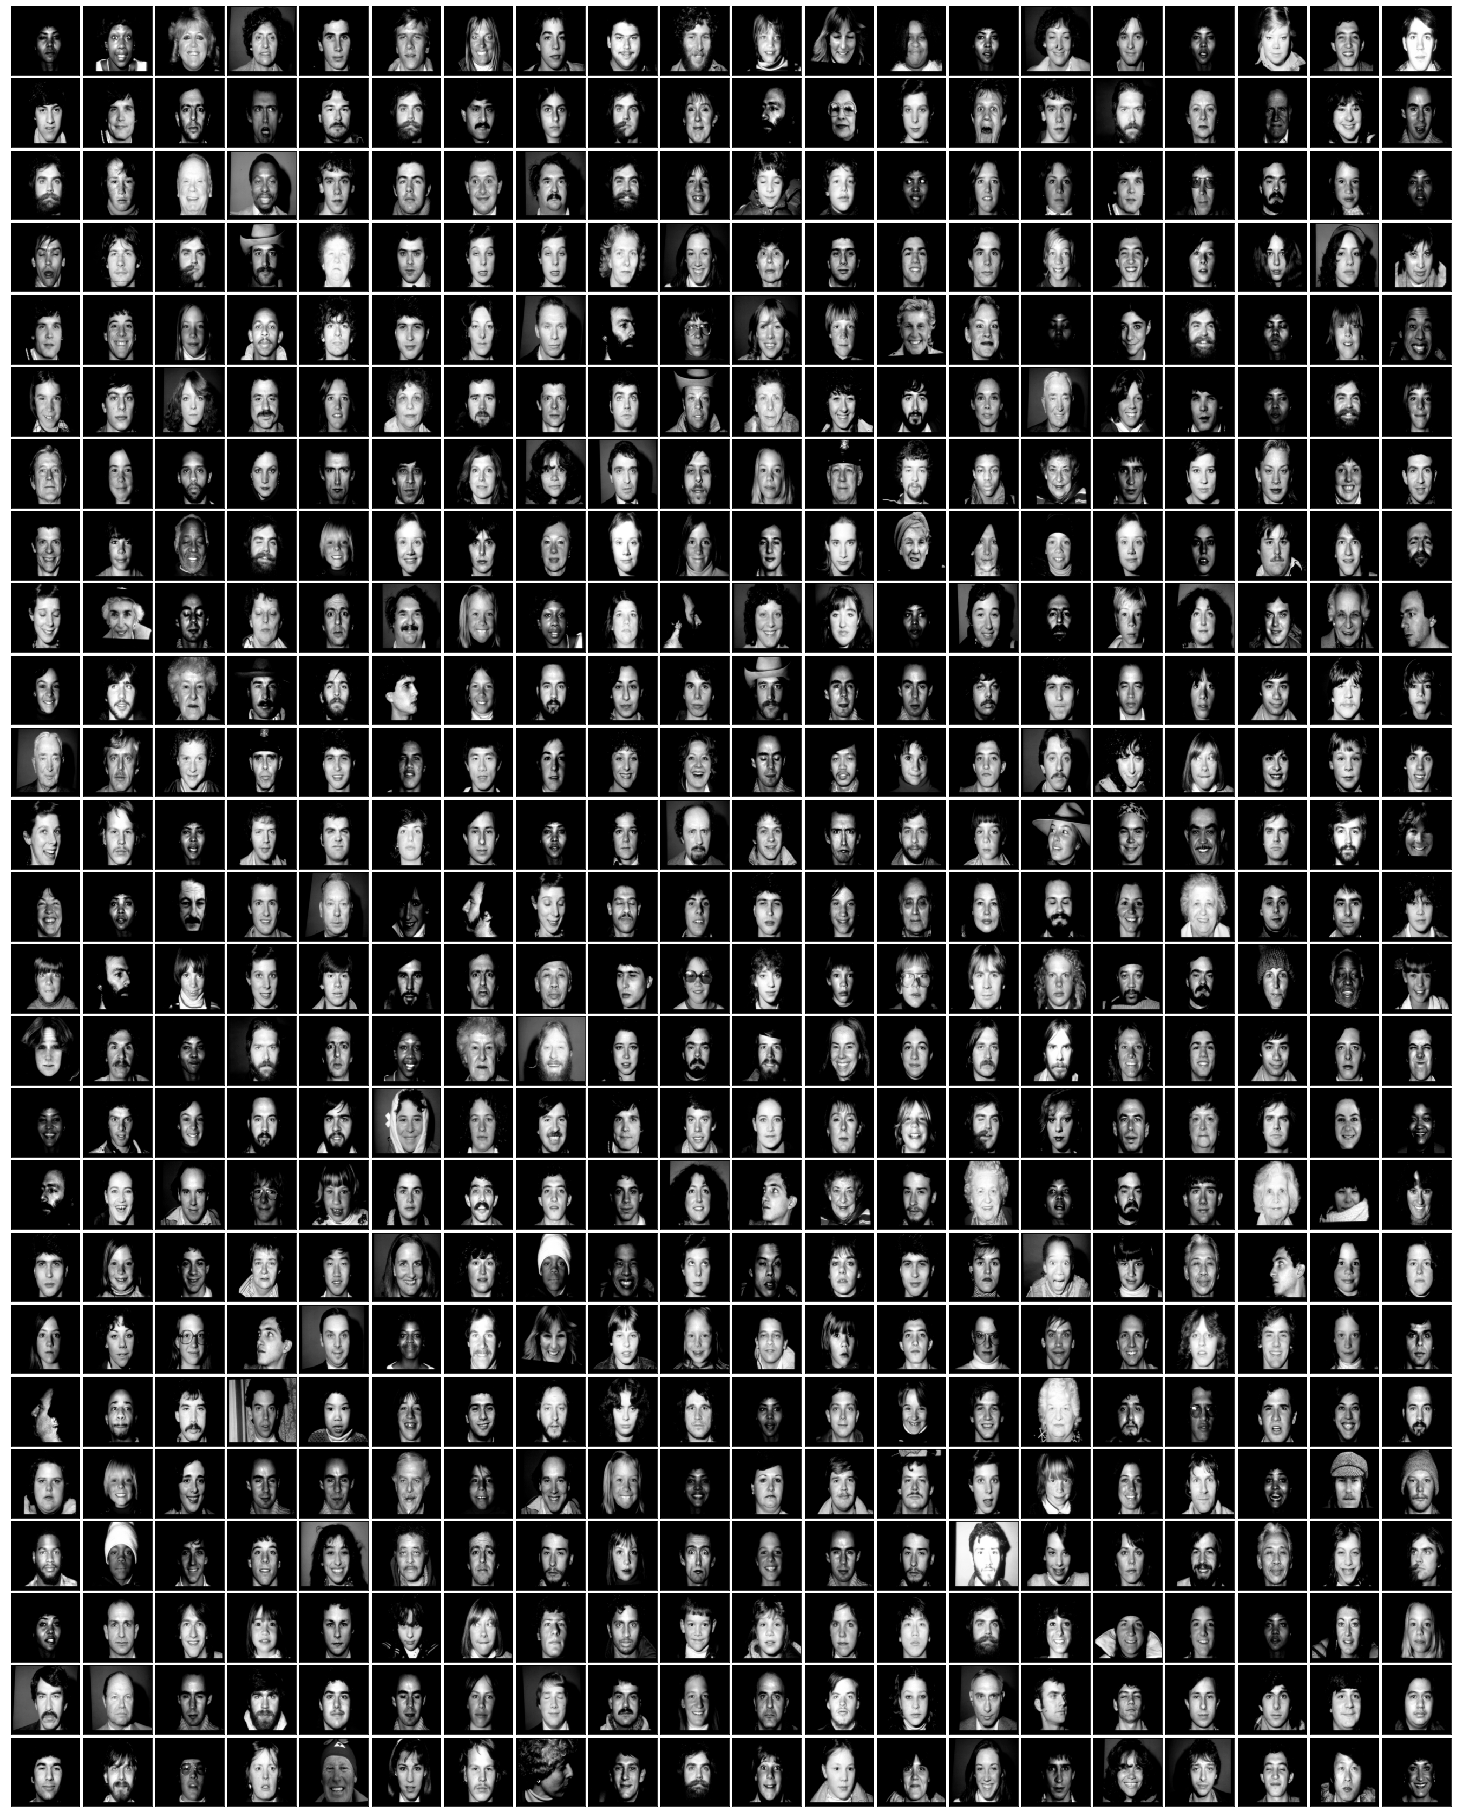

In [ ]:
np.random.seed(0)
indexes = np.random.choice(range(len(all_images)), 500)
plot_faces(all_images, 20, 25, indexes, "opencv")

In [ ]:
min_rows, min_cols = sys.maxsize, sys.maxsize
max_rows, max_cols = 0, 0
for (i, image) in enumerate(all_images):
    r, c = image.shape[0], image.shape[1]
    min_rows = min(min_rows, r)
    max_rows = max(max_rows, r)
    min_cols = min(min_cols, c)
    max_cols = max(max_cols, c)
    
print("\n==> Tamaño de la imagen más pequeña:", min_rows, "x", min_cols, "píxeles")
print("==> Tamaño de la imagen más grande:", max_rows, "x", max_cols, "píxeles")


==> Tamaño de la imagen más pequeña: 128 x 128 píxeles
==> Tamaño de la imagen más grande: 512 x 512 píxeles


1178
Imagen original:


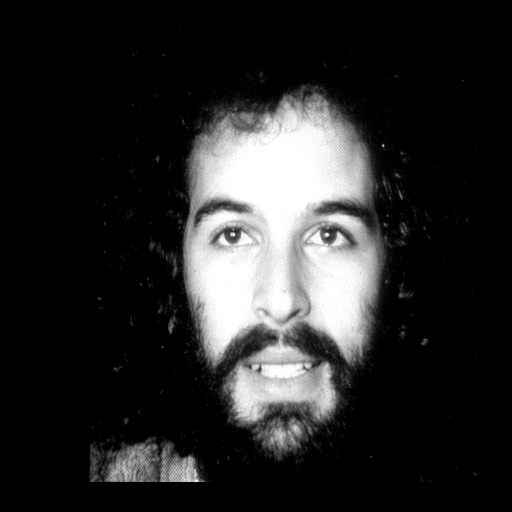

Imagen redimensionada:


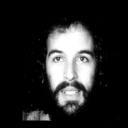

1182
Imagen original:


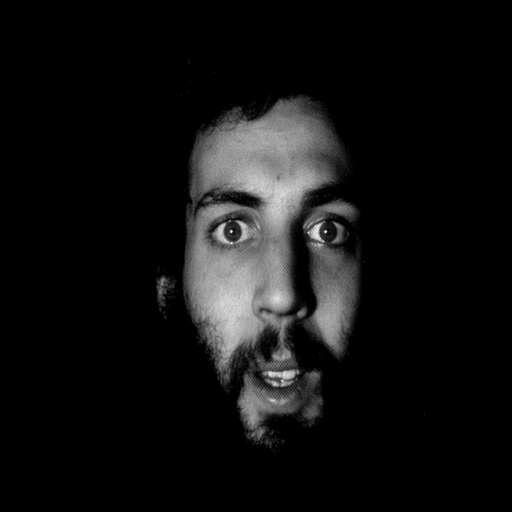

Imagen redimensionada:


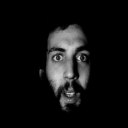

In [ ]:
# Se redimensionan las imágenes mayores al tamaño mínimo

resized_images = []
i = 0
for image in all_images:
  img = image
  if image.shape != (min_rows, min_cols):
    print(i)
    print("Imagen original:")
    cv2_imshow(image)
    img = cv2.resize(img, (min_rows, min_cols), interpolation = cv2.INTER_AREA)
    print("Imagen redimensionada:")
    cv2_imshow(img)
  i += 1
  resized_images.append(img)

In [ ]:
len(resized_images)

3956

Para trabajar de forma más sencilla (y porque **PCA requiere matrices o arreglos de datos**), se convierten las imágenes a un dataset con una fila por imagen y una columna por píxel (es decir, 16384 columnas) con los valores de píxeles normalizados (convertidos de un rango de 0 a 255, a un rango de 0 a 1).

In [ ]:
normalized_images = []
for image in resized_images:
  img = np.ravel(image)
  pixels = img.astype('float32')
  pixels /= 255.0
  normalized_images.append(pixels)

In [ ]:
faces_df = pd.DataFrame(normalized_images)

In [ ]:
faces_df.head()

0      1      2      3      4      ...  16379  16380  16381  16382  16383
0    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
1    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
2    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
3    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0
4    0.0    0.0    0.0    0.0    0.0  ...    0.0    0.0    0.0    0.0    0.0

[5 rows x 16384 columns]

In [ ]:
faces_df.to_numpy().shape

(3956, 16384)

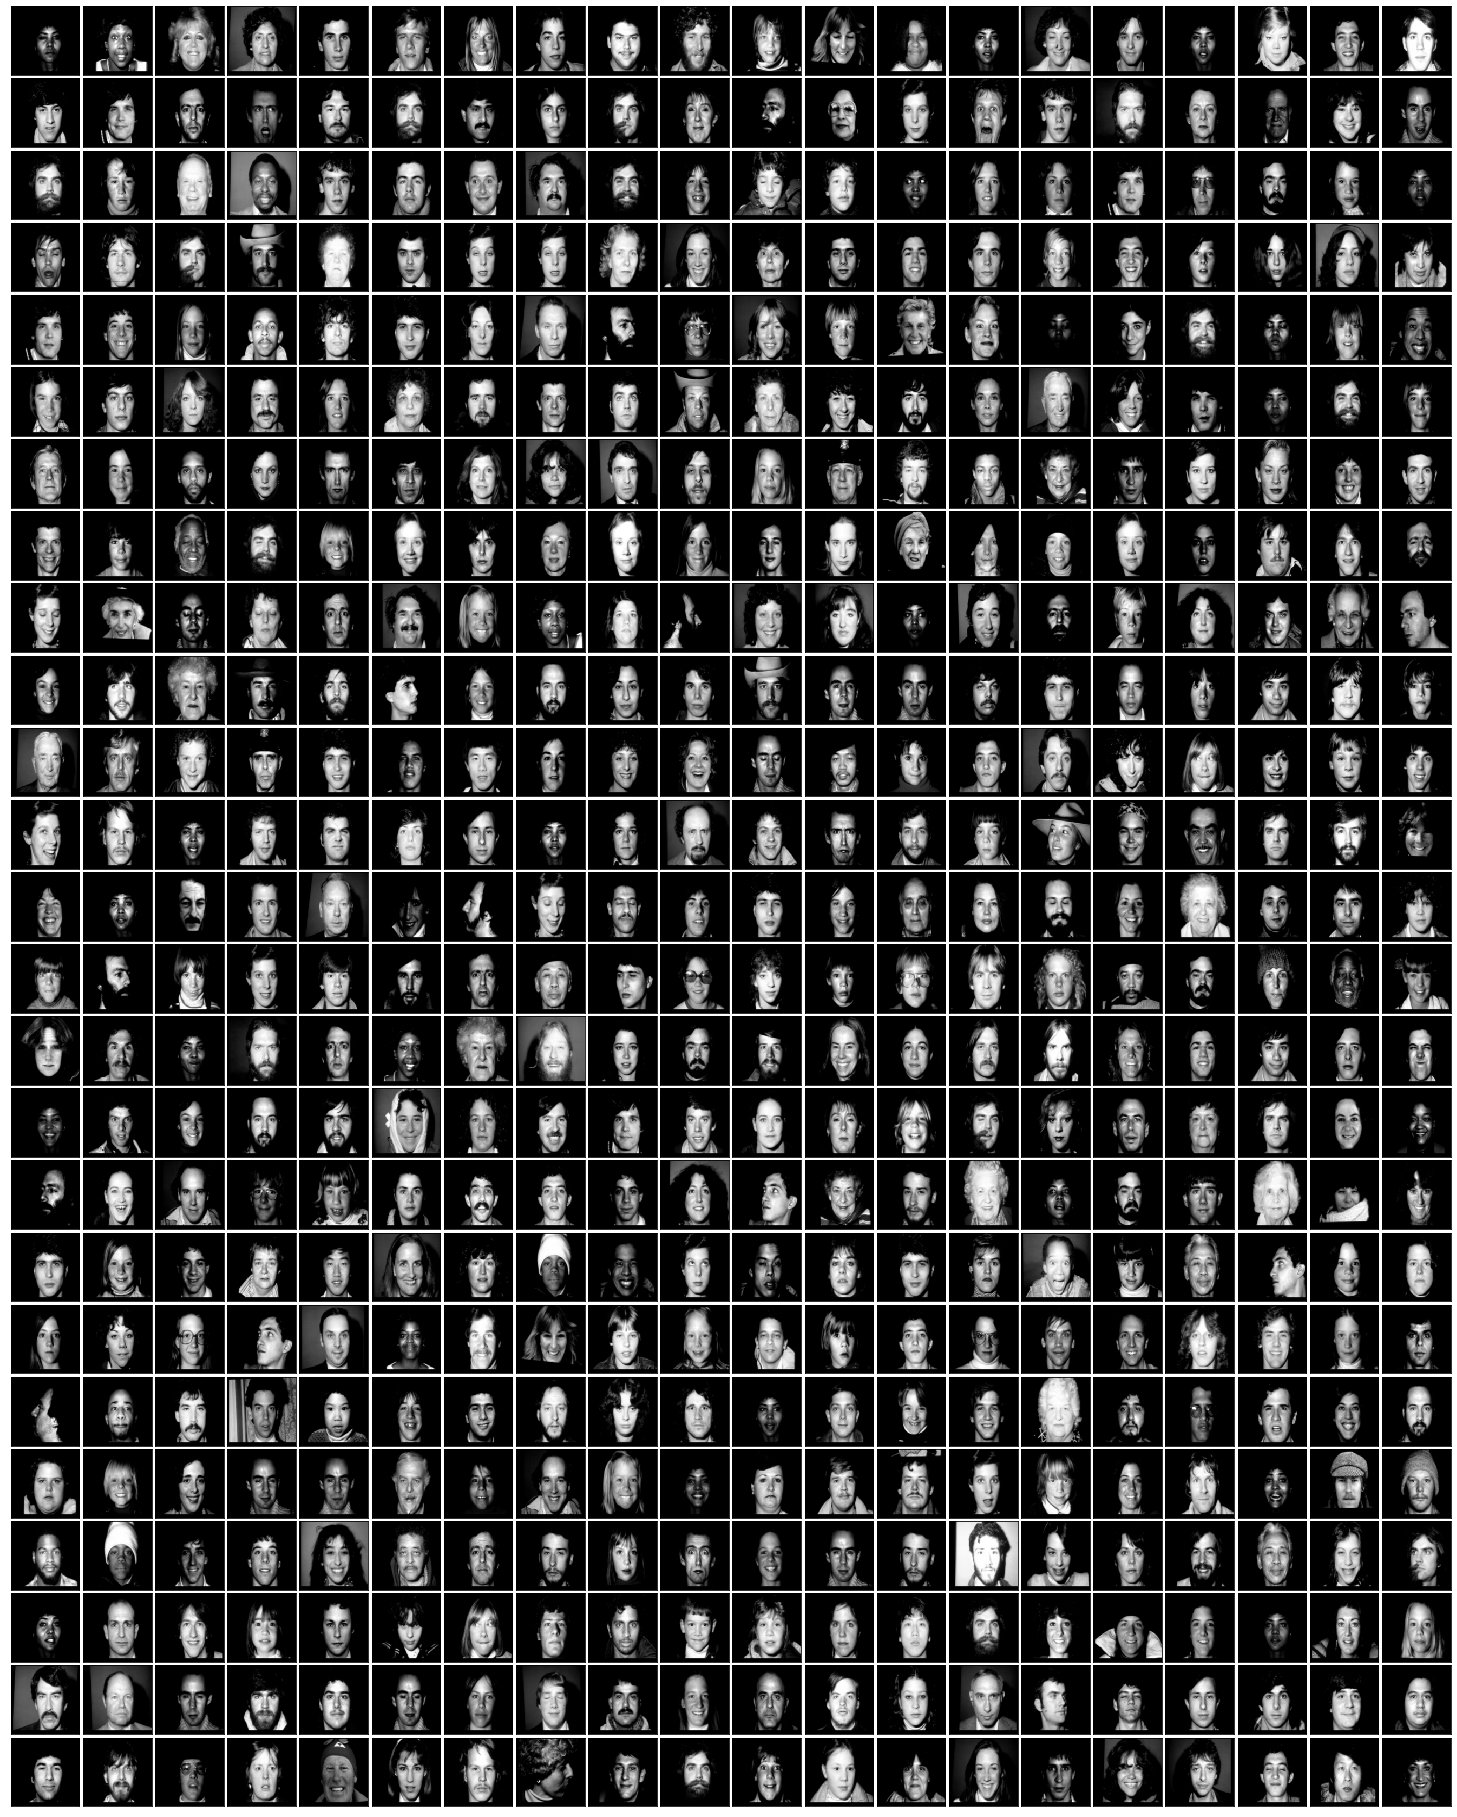

In [ ]:
# Se muestran las mismas imágenes que se mostraron anteriormente, reconstruidas a partir del dataframe con píxeles normalizados
plot_faces(faces_df, 20, 25, indexes, "df")

##2. PCA y obtención de imagen promedio

In [ ]:
X = faces_df.to_numpy()

# Obtención de la descomposición en valores singulares
U, S, VT = np.linalg.svd(X, full_matrices = False)

print("X:", X.shape)
print("U:", U.shape)
print("Sigma:", S.shape)
print("V^T:", VT.shape)

X: (3956, 16384)
U: (3956, 3956)
Sigma: (3956,)
V^T: (3956, 16384)


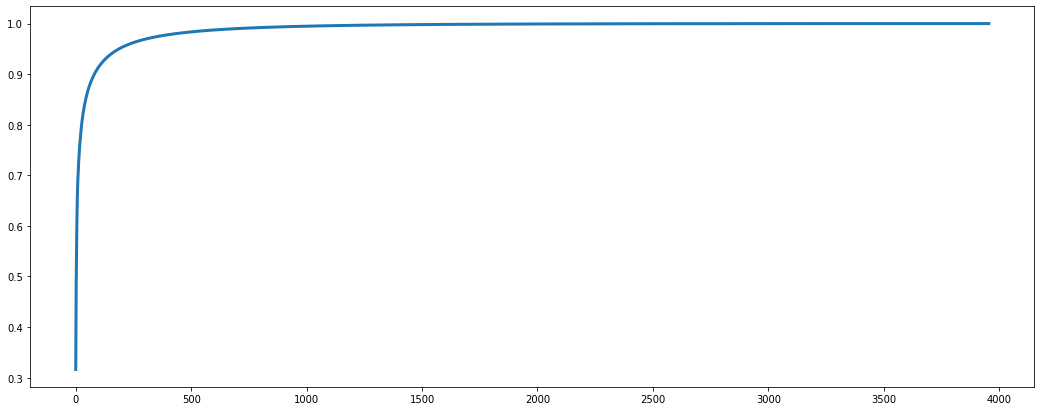

In [ ]:
# Cálculo de número de componentes para obtener una varianza aceptable (99% en este caso)

pca = PCA().fit(faces_df)

plt.figure(figsize=(18, 7))
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3)

In [ ]:
min_components = np.where(pca.explained_variance_ratio_.cumsum() > 0.99)[0][0]
print("Mínimo número de componentes para obtener una suma acumulada del 99% en la varianza: ", str(min_components))

Mínimo número de componentes para obtener una suma acumulada del 99% en la varianza:  695


In [ ]:
print("Componentes totales: ", str(pca.n_components_))

Componentes totales:  3956


In [ ]:
# Cálculo de los eigenfaces

components = min_components

# Imagen promedio
mean_image = X.mean(axis=0)
print("Magnitud de la imagen promedio: ", mean_image.shape)

# Matriz A para obtener matriz de covarianza
A = (X - mean_image).T
print("Magnitud de la matriz A: ", A.shape)

# Matriz de covarianza, de tamaño n*n, donde n es el número de imágenes
M = A.T @ A
print("Magnitud de la matriz de covarianza: ", M.shape)

# Eigenvectores
mu, V = np.linalg.eig(M) # mu = eigenvalores, V = eigenvectores
mu = np.abs(mu) # Magnitud de los eigenvalores
print("Magnitud de los eigenvectores: ", V.shape)
print("Tamaño de la matriz de eigenvalores: ", mu.shape) # Tamaño de la matriz de eigenvalores

# Se ordenan los índices de forma descendente, con base en la magnitud de los eigenvalores
sorted_mu = np.argsort(-1 * mu)

# Eigenvectores de la matriz de covarianza
u = np.array([])
for i in sorted_mu[:components]: # Se obtienen los primeros 695 eigenvalores
    ui = A @ V[:, i].T # Se obtiene el vector de los 695 eigenvectores de la matriz de covarianza
    #ui = ui_temp / np.linalg.norm(ui_temp) # Normalización
    
    if len(u) == 0: # La matriz es igual al primer eigenvector
        u = ui
    else: # El resto de eigenvectores se apilan verticalmente
        u = np.vstack((u, ui))

u = u.T
print("Magnitud de la matriz de eigenvectores: ", str(u.shape))

Magnitud de la imagen promedio:  (16384,)
Magnitud de la matriz A:  (16384, 3956)
Magnitud de la matriz de covarianza:  (3956, 3956)
Magnitud de los eigenvectores:  (3956, 3956)
Tamaño de la matriz de eigenvalores:  (3956,)
Magnitud de la matriz de eigenvectores:  (16384, 695)


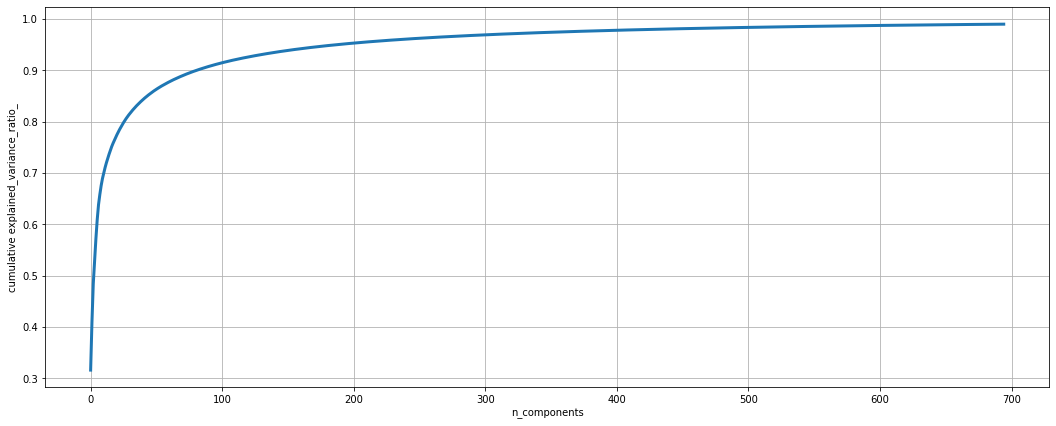

In [ ]:
pca = PCA(695).fit(faces_df)
plt.figure(figsize=(18, 7))
plt.grid(), plt.xlabel('n_components'), plt.ylabel('cumulative explained_variance_ratio_')
plt.plot(pca.explained_variance_ratio_.cumsum(), lw = 3)
plt.show()

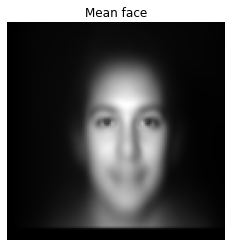

In [ ]:
plt.imshow(np.reshape(mean_image, (128, 128)), cmap = plt.cm.gray)
plt.axis('off'), plt.title('Mean face')
plt.show()

In [ ]:
eigenfaces = np.diag(mu[:components]) @ u.T # Multiplicación de eigenvectores por sus eigenvalores
print(eigenfaces.shape)

(695, 16384)


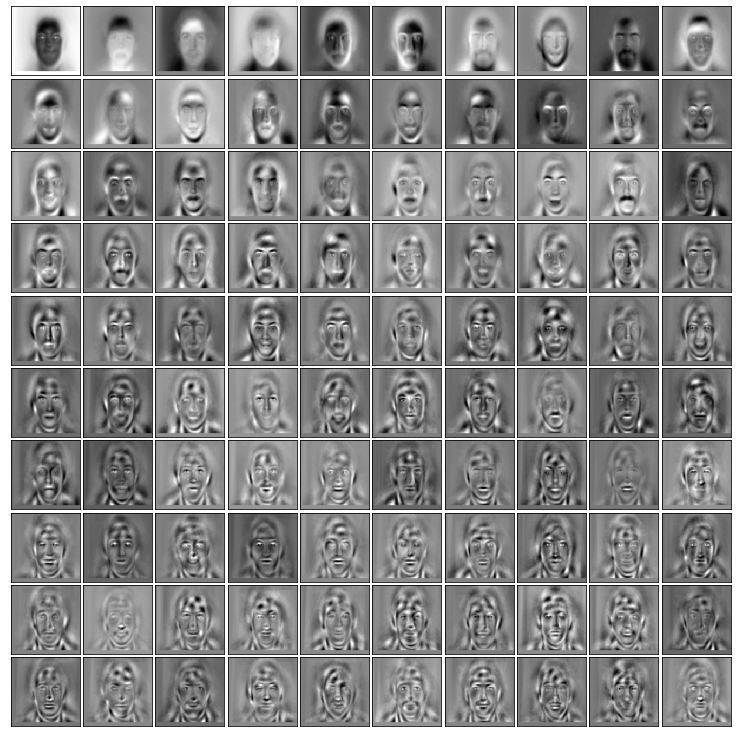

In [ ]:
# Primeras 100 eigenfaces

plot_faces(eigenfaces, 10, 10, range(0, 100), "np", "inv")

##3. Reconstrucción

In [ ]:
def test_faces(test_indexes, title = []):
  test_images = []
  fig = plt.figure(figsize = (10, 2))
  fig.subplots_adjust(left = 0, right = 3, bottom = 0, top = 5, hspace = 0.05, wspace = 0.05)
  i = 1

  for index in test_indexes:
    image = np.reshape(resized_images[index], (128, 128))
    ax = fig.add_subplot(2, 10, i, xticks = [], yticks = [])
    ax.imshow(np.reshape(image, (128, 128)), cmap = plt.cm.gray, interpolation='nearest')
    if not title:
      title_test = "Imagen de prueba " + str(i)
      plt.axis('off'), plt.title(title_test)
    else:
      plt.axis('off'), plt.title(title[i-1])
    test_images.append(image.flatten())
    i += 1
  plt.show()

  return test_images

In [ ]:
def reconstruct(image, range_efaces, name_extra = ""):
  filenames = []
  values, residuals, rank, singular = np.linalg.lstsq(u, image, rcond = None)

  %mkdir temp_images
  %cd temp_images

  for f in range_efaces:
    # Crea la imagen
    reconstructed_image = u[:, :f] @ values[:f]
    reconstructed_image = np.reshape(reconstructed_image + mean_image, (128, 128))
    plt.imshow(np.reshape(reconstructed_image, (128, 128)), cmap = plt.cm.gray)
    if not name_extra:
      title = "#efaces: " + str(f)
    elif name_extra == "first":
      title = "first face #efaces: " + str(f)
    elif name_extra == "last":
      title = "second face #efaces: " + str(f)
    plt.axis('off'), plt.title(title)

    # Nombre del archivo
    if not name_extra:
      filename = f'{f}.png'
    else:
      filename = name_extra + str(f) + ".png"

    # Se guarga la imagen
    plt.savefig(filename)
    
    #print(f)
    if f == 695 or f == 400 or f == 200 or f == 100 or f == 50 or f == 10:
      plt.show()
    plt.close()

    filename = "/content/temp_images/" + str(filename)
    filenames.append(filename)

  %cd ..

  return filenames

In [ ]:
def get_gif(filenames, name):
  with imageio.get_writer(name, mode = 'I') as writer:
    for filename in filenames:
      image = imageio.imread(filename)
      writer.append_data(image)

  %rm -rf temp_images

In [ ]:
test_indexes = np.random.randint(len(resized_images), size = 5)

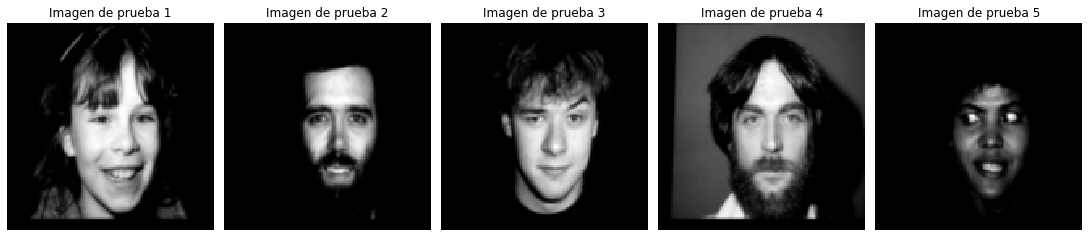

In [ ]:
test_images = test_faces(test_indexes)

In [ ]:
range_efaces = range(1, 696) # Número de eigenfaces para la reconstrucción

/content/temp_images


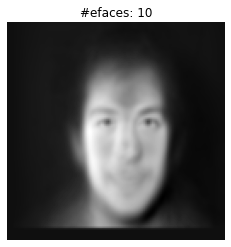

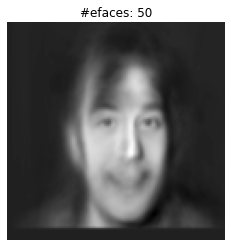

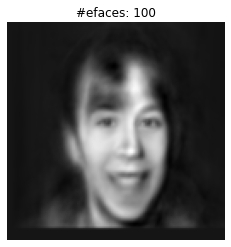

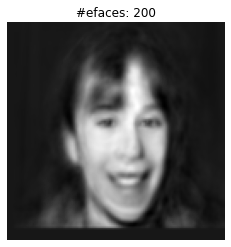

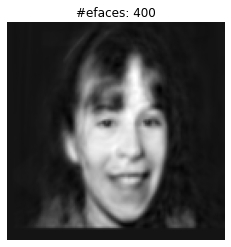

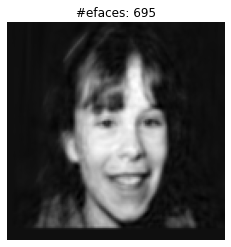

/content
/content/temp_images


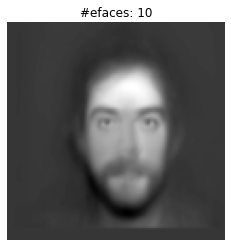

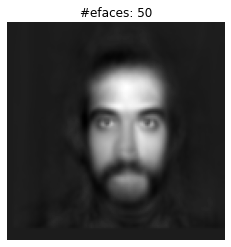

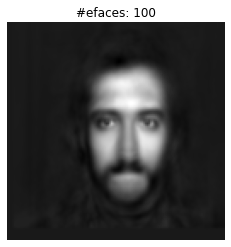

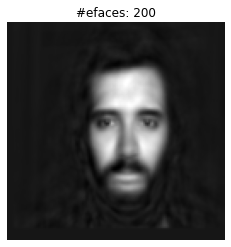

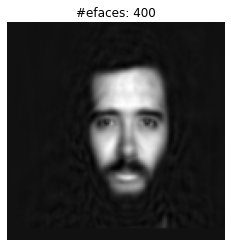

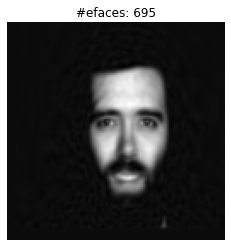

/content
/content/temp_images


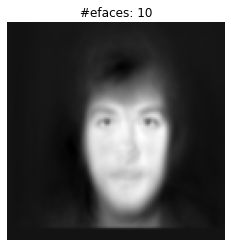

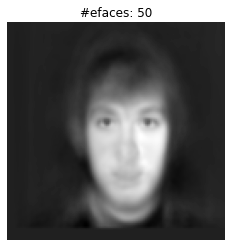

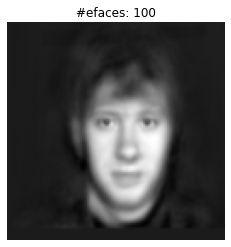

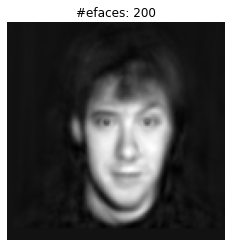

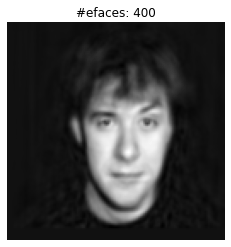

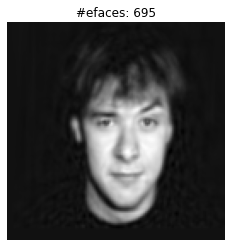

/content
/content/temp_images


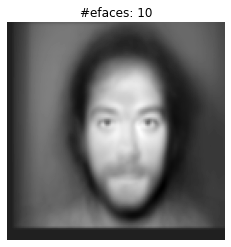

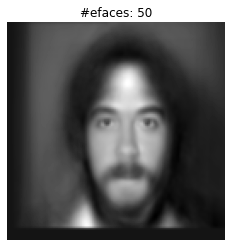

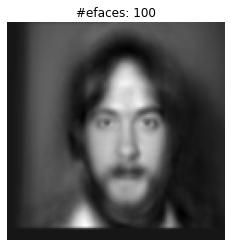

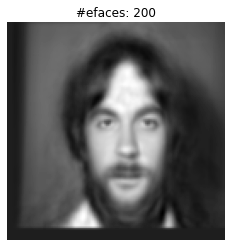

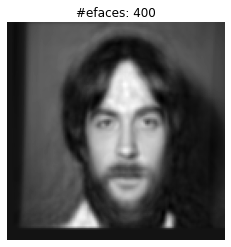

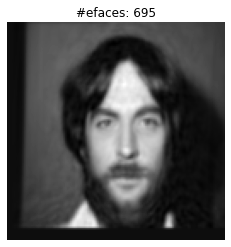

/content
/content/temp_images


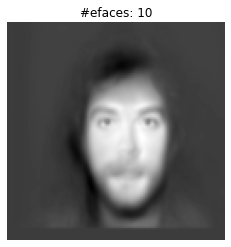

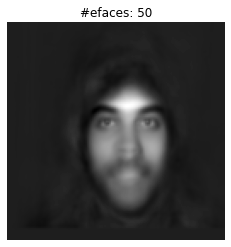

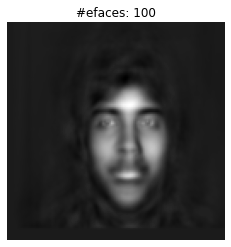

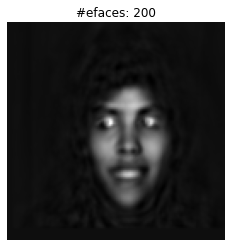

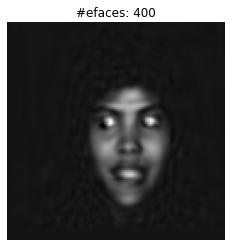

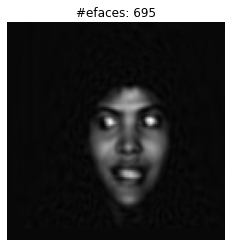

/content


In [ ]:
i = 1
for image in test_images:
  filenames = reconstruct(image, range_efaces)
  name = "result" + str(i) + ".gif"
  get_gif(filenames, name)
  i += 1

## 4. Face morphing

In [ ]:
test_indexes_morph = np.random.randint(len(resized_images), size = 2)

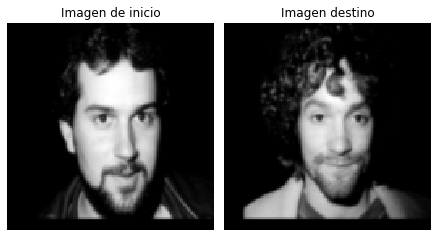

In [ ]:
names = ["Imagen de inicio", "Imagen destino"]
test_images_morph = test_faces(test_indexes_morph, names)

/content/temp_images


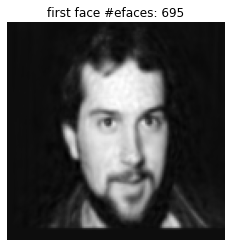

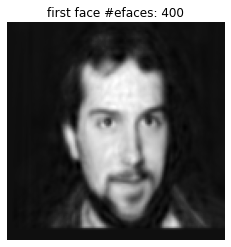

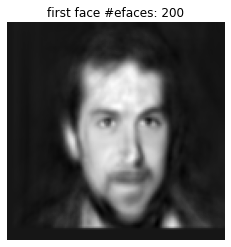

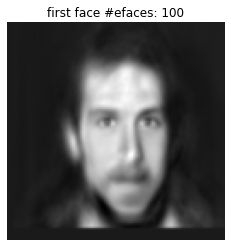

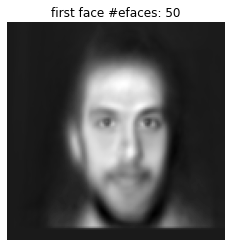

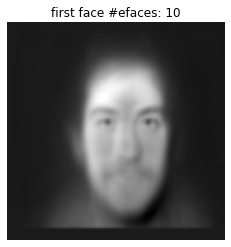

/content
mkdir: cannot create directory ‘temp_images’: File exists
/content/temp_images


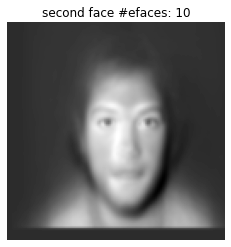

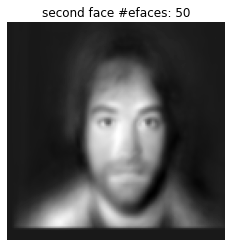

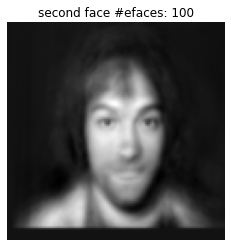

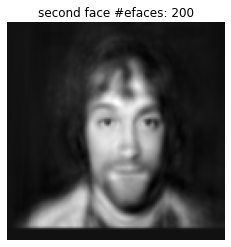

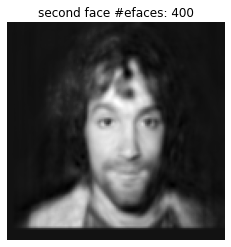

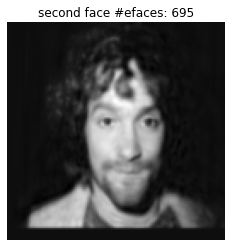

/content


In [ ]:
range_efaces_first = range(695, 9, -1)
range_efaces_last = range(10, 696, 1)

filenames = reconstruct(test_images_morph[0], range_efaces_first, "first")
filenames = filenames + reconstruct(test_images_morph[1], range_efaces_last, "last")


In [ ]:
get_gif(filenames, "morph.gif")